In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import torch
import re
from pathlib import Path
import pickle as pkl
import numpy as np
import pandas as pd
from tqdm.autonotebook import trange, tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import transforms as T
from core.utils.plot_utils import saveallforms
from core.utils.dataset_utils import ImagePathDataset_pure
from neuro_data_analysis.neural_data_utils import get_all_masks
from neuro_data_analysis.neural_data_lib import load_img_resp_pairs, load_neural_data, get_expstr
from lpips import LPIPS
# from ultralytics import YOLO
# model_new = YOLO("yolov8x.pt")
tabdir = Path(r"E:\OneDrive - Harvard University\Manuscript_BigGAN\Stats_tables")
meta_df = pd.read_csv(tabdir / "meta_activation_stats.csv", index_col=0)

In [3]:
_, BFEStats = load_neural_data()

In [7]:
saveroot = Path(r"E:\OneDrive - Harvard University\Manuscript_BigGAN\Figures\Evol_ImgDist_curve")
syndir = saveroot / "synopsis"
syndir.mkdir(parents=True, exist_ok=True)

### Loading from stats df

In [8]:
# go through the experiments and crowd source the data
dist_stats_syn_df = []
for Expi in trange(1, 190+1):
    if BFEStats[Expi-1]["evol"] is None:
        continue
    expdir = saveroot / f"Both_Exp{Expi}"
    dist_stats_df = pd.read_csv(expdir / f"block_distmat_stats.csv", index_col=0)
    dist_stats_df["Expi"] = Expi
    dist_stats_syn_df.append(dist_stats_df)
dist_stats_syn_df = pd.concat(dist_stats_syn_df)
dist_stats_syn_df.to_csv(syndir / "block_distmat_stats_syn_df.csv")

100%|██████████| 190/190 [00:00<00:00, 639.58it/s]


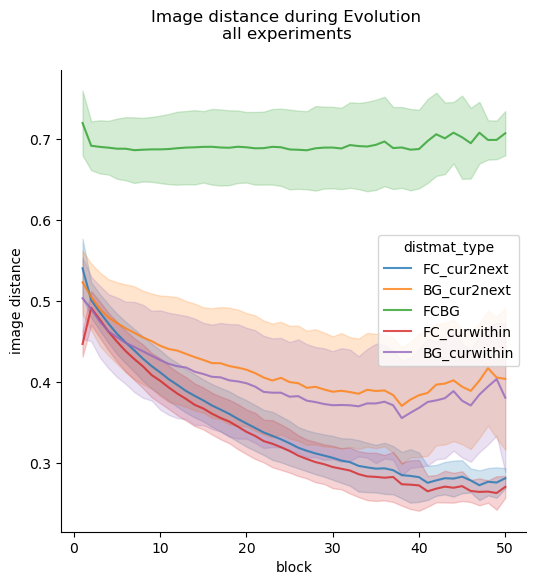

In [12]:
plt.figure(figsize=[6, 6])
sns.lineplot(data=dist_stats_syn_df.query("block <= 50"), x="block", y="mean", hue="distmat_type", lw=1.5, alpha=0.8, legend=True, errorbar="sd", estimator="mean", n_boot=0)
plt.ylabel("image distance")
plt.xlabel("block")
plt.suptitle("Image distance during Evolution\nall experiments")
saveallforms(str(syndir), "block_distmat_curve_avg_std_all")
plt.show()


In [41]:
meta_df.loc[6]

Animal                         Beto
expdate                  2020-07-27
ephysFN           Beto-27072020-002
prefchan                         26
prefunit                          1
visual_area                      IT
space1                          fc6
space2                 BigGAN_class
optim_names1                  CMAES
optim_names2                  CMAES
blockN                           38
t_endinit_0                4.015139
p_endinit_0                0.000094
t_endinit_1                8.123102
p_endinit_1                     0.0
t_maxinit_0                4.879438
p_maxinit_0                0.000003
t_maxinit_1                9.540134
p_maxinit_1                     0.0
t_maxend_0                 1.336675
p_maxend_0                  0.18325
t_maxend_1                 1.098719
p_maxend_1                 0.274583
t_FCBG_end_01            -10.973014
p_FCBG_end_01                   0.0
t_FCBG_max_01            -10.511867
p_FCBG_max_01                   0.0
maxrsp_0_mean             18

In [42]:
meta_df.loc[149]

Animal                          Alfa
expdate                   2020-10-29
ephysFN            Alfa-29102020-002
prefchan                          27
prefunit                           2
visual_area                       IT
space1                           fc6
space2                        BigGAN
optim_names1                   CMAES
optim_names2      Concat CMAES CMAES
blockN                            35
t_endinit_0                 7.228179
p_endinit_0                      0.0
t_endinit_1                 1.077266
p_endinit_1                 0.283784
t_maxinit_0                  8.70785
p_maxinit_0                      0.0
t_maxinit_1                 1.749228
p_maxinit_1                 0.083119
t_maxend_0                   1.13158
p_maxend_0                  0.259525
t_maxend_1                  0.462381
p_maxend_1                  0.644833
t_FCBG_end_01               2.700082
p_FCBG_end_01                0.00787
t_FCBG_max_01               3.698051
p_FCBG_max_01               0.000321
m

### Show the image distance during evolution for each mask

In [14]:
Amsk, Bmsk, V1msk, V4msk, ITmsk, length_msk, spc_msk, \
    sucsmsk, bsl_unstable_msk, bsl_stable_msk, validmsk = get_all_masks(meta_df)
bothsucmsk = (meta_df.p_maxinit_0 < 0.05) & (meta_df.p_maxinit_1 < 0.05)
FCsucsmsk = (meta_df.p_maxinit_0 < 0.05)
BGsucsmsk = (meta_df.p_maxinit_1 < 0.05)

total number of experiments: 170
total number of valid experiments: 154
total number of valid experiments with suc: 133
Exluded:
  - short: 8
  - unstable baseline: 6
  - not fc6-BigGAN: 3


In [22]:
bothsucmsk = (meta_df.p_maxinit_0 < 0.01) & (meta_df.p_maxinit_1 < 0.01)
FCsucsmsk = (meta_df.p_maxinit_0 < 0.01)
BGsucsmsk = (meta_df.p_maxinit_1 < 0.01)

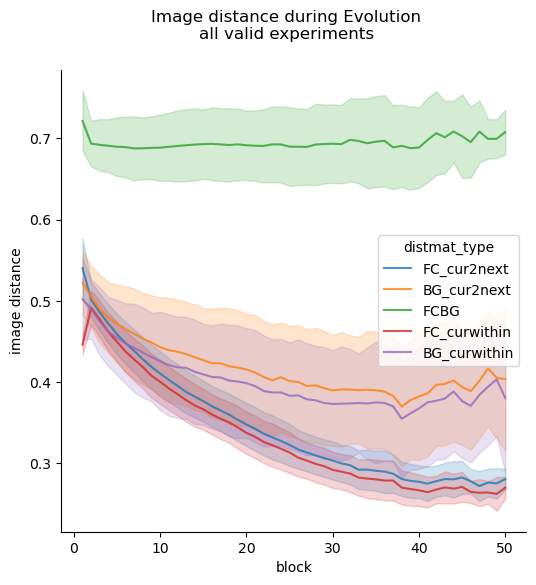

In [33]:
Exp_lists = validmsk[validmsk].index
plt.figure(figsize=[6, 6])
sns.lineplot(data=dist_stats_syn_df.query("block <= 50 and Expi in @Exp_lists"), 
             x="block", y="mean", hue="distmat_type", 
             lw=1.5, alpha=0.8, legend=True, errorbar="sd", estimator="mean", n_boot=0)
plt.ylabel("image distance")
plt.xlabel("block")
plt.suptitle("Image distance during Evolution\nall valid experiments")
saveallforms(str(syndir), "block_distmat_curve_avg_std_valid")
plt.show()

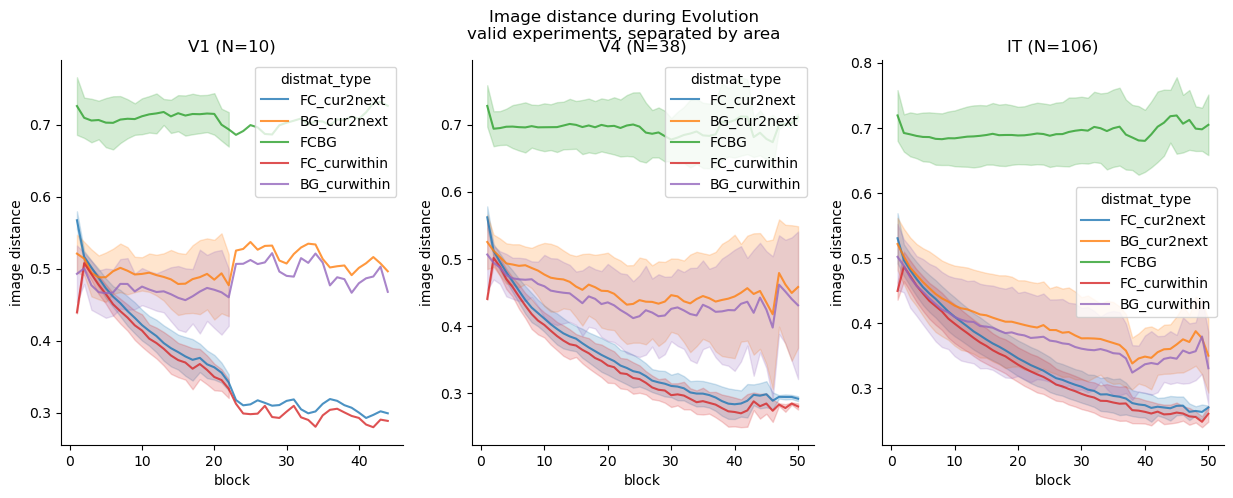

In [37]:
figh, axs = plt.subplots(1, 3, figsize=[15, 5])
for ax, mask, mask_name in zip(axs.flatten(), [V1msk & validmsk, V4msk & validmsk, ITmsk & validmsk], ["V1", "V4", "IT"]):   
    Exp_lists = mask[mask].index
    sns.lineplot(data=dist_stats_syn_df.query("block <= 50 and Expi in @Exp_lists"), 
                x="block", y="mean", hue="distmat_type", 
                lw=1.5, alpha=0.8, legend=True, errorbar="sd", estimator="mean", n_boot=0, 
                ax=ax)
    ax.set_ylabel("image distance")
    ax.set_xlabel("block")
    ax.set_title(f"{mask_name} (N={len(Exp_lists)})")
plt.suptitle("Image distance during Evolution\nvalid experiments, separated by area")
saveallforms(str(syndir), "block_distmat_curve_avg_std_valid_V1_V4_IT_sep")
plt.show()

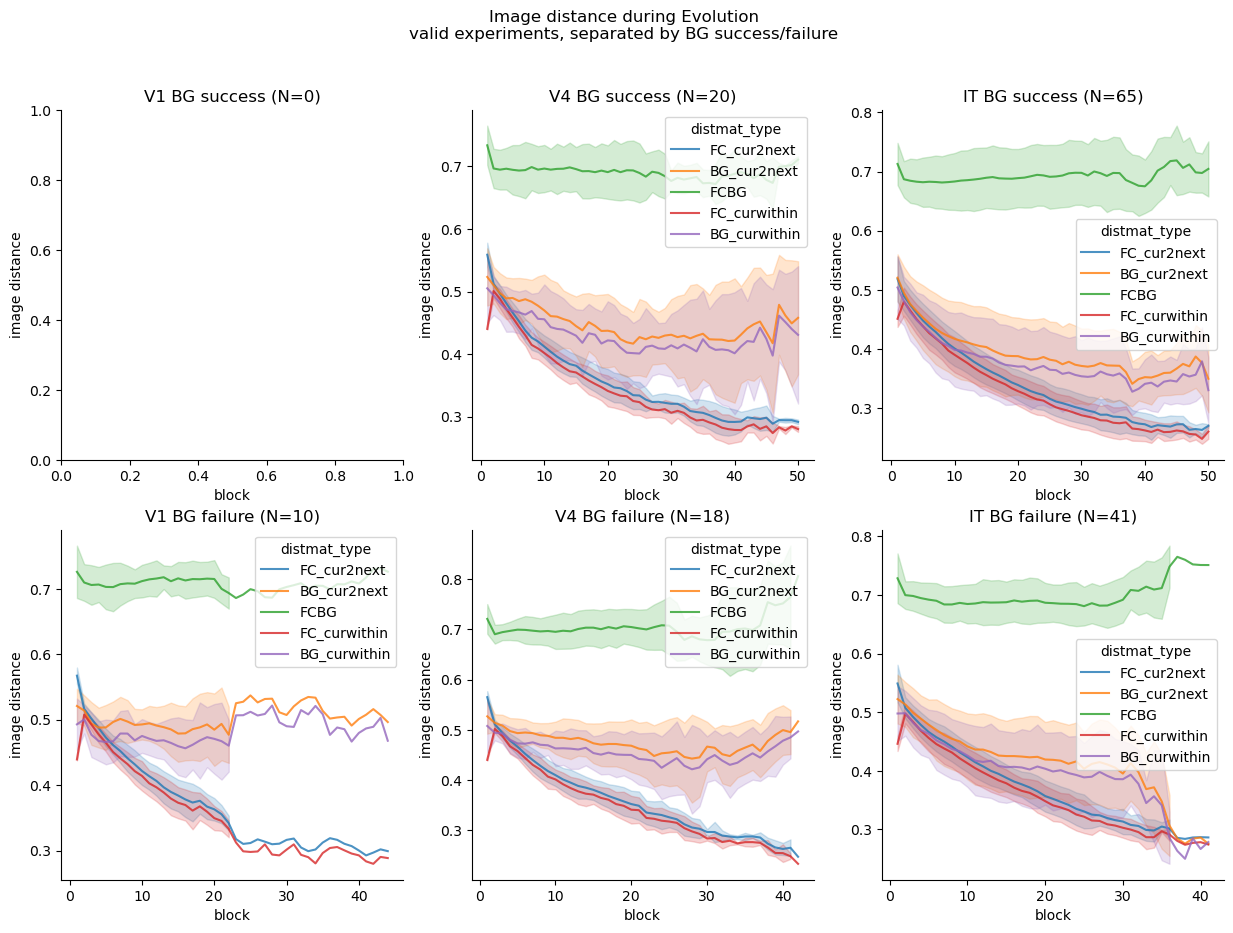

In [36]:
figh, axs = plt.subplots(2, 3, figsize=[15, 10])
for ax, mask, mask_name in zip(axs.flatten(), [V1msk & validmsk & BGsucsmsk, V4msk & validmsk & BGsucsmsk, ITmsk & validmsk & BGsucsmsk,
                                               V1msk & validmsk & ~BGsucsmsk, V4msk & validmsk & ~BGsucsmsk, ITmsk & validmsk & ~BGsucsmsk,], 
                               ["V1 BG success", "V4 BG success", "IT BG success", "V1 BG failure", "V4 BG failure", "IT BG failure"]):   
    Exp_lists = mask[mask].index
    sns.lineplot(data=dist_stats_syn_df.query("block <= 50 and Expi in @Exp_lists"), 
                x="block", y="mean", hue="distmat_type", 
                lw=1.5, alpha=0.8, legend=True, errorbar="sd", estimator="mean", n_boot=0, 
                ax=ax)
    ax.set_ylabel("image distance")
    ax.set_xlabel("block")
    ax.set_title(f"{mask_name} (N={len(Exp_lists)})")
plt.suptitle("Image distance during Evolution\nvalid experiments, separated by BG success/failure")
saveallforms(str(syndir), "block_distmat_curve_avg_std_valid_V1_V4_IT_BG_suc_fail_sep")
plt.show()

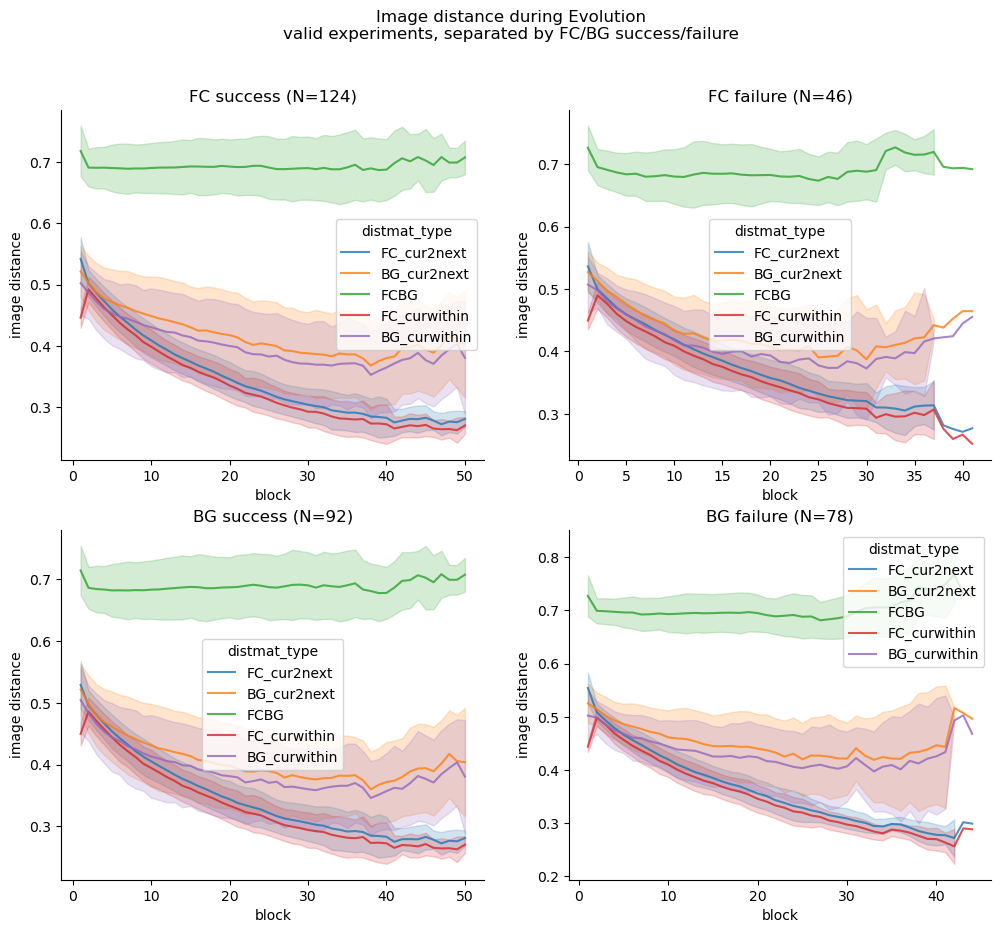

In [38]:
figh, axs = plt.subplots(2, 2, figsize=[12, 10])
for ax, mask, mask_name in zip(axs.flatten(), [FCsucsmsk, ~FCsucsmsk, BGsucsmsk, ~BGsucsmsk], ["FC success", "FC failure", "BG success", "BG failure"]):   
    Exp_lists = mask[mask].index
    sns.lineplot(data=dist_stats_syn_df.query("block <= 50 and Expi in @Exp_lists"), 
                x="block", y="mean", hue="distmat_type", 
                lw=1.5, alpha=0.8, legend=True, errorbar="sd", estimator="mean", n_boot=0, 
                ax=ax)
    ax.set_ylabel("image distance")
    ax.set_xlabel("block")
    ax.set_title(f"{mask_name} (N={len(Exp_lists)})")
plt.suptitle("Image distance during Evolution\nvalid experiments, separated by FC/BG success/failure")
saveallforms(str(syndir), "block_distmat_curve_avg_std_valid_FC_BG_suc_fail_sep")
plt.show()

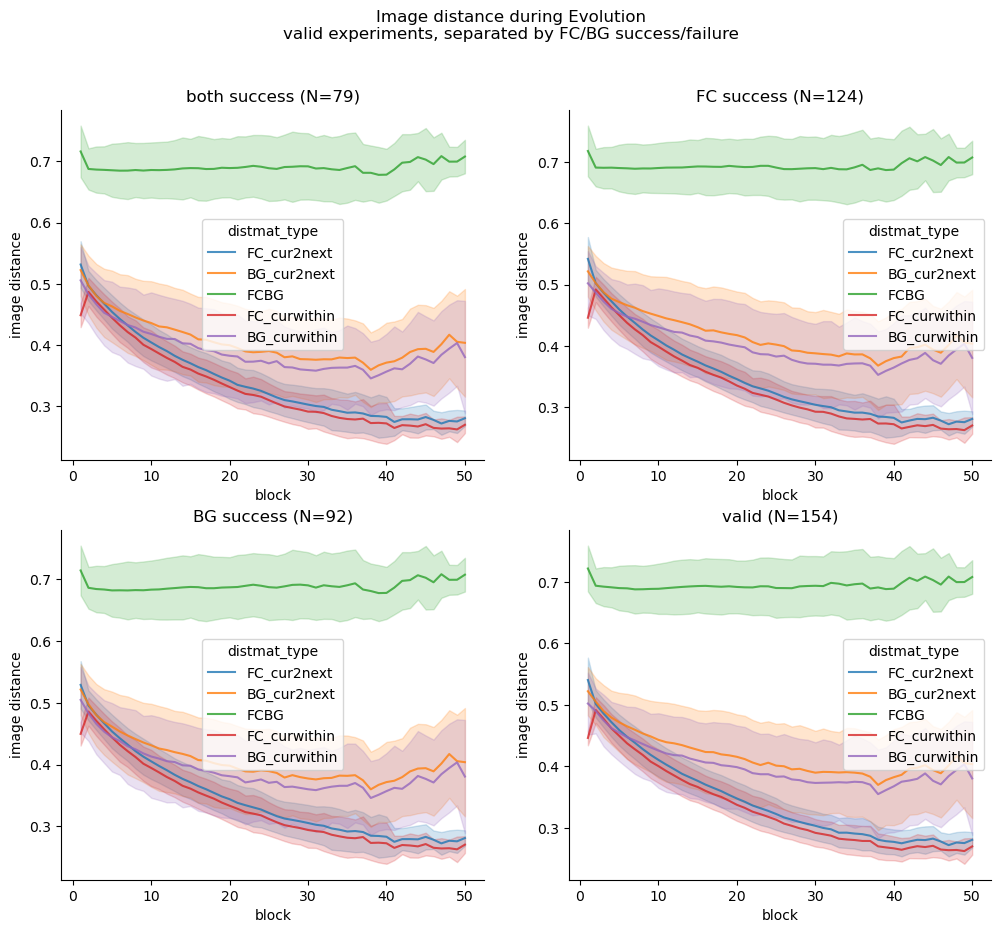

In [39]:
figh, axs = plt.subplots(2, 2, figsize=[12, 10])
for ax, mask, mask_name in zip(axs.flatten(), [bothsucmsk, FCsucsmsk, BGsucsmsk, validmsk], ["both success", "FC success", "BG success", "valid"]):   
    Exp_lists = mask[mask].index
    sns.lineplot(data=dist_stats_syn_df.query("block <= 50 and Expi in @Exp_lists"), 
                x="block", y="mean", hue="distmat_type", 
                lw=1.5, alpha=0.8, legend=True, errorbar="sd", estimator="mean", n_boot=0, 
                ax=ax)
    ax.set_ylabel("image distance")
    ax.set_xlabel("block")
    ax.set_title(f"{mask_name} (N={len(Exp_lists)})")
plt.suptitle("Image distance during Evolution\nvalid experiments, separated by FC/BG success/failure")
saveallforms(str(syndir), "block_distmat_curve_avg_std_valid_both_FC_BG_suc_fail_sep")
plt.show()


### Paired plot

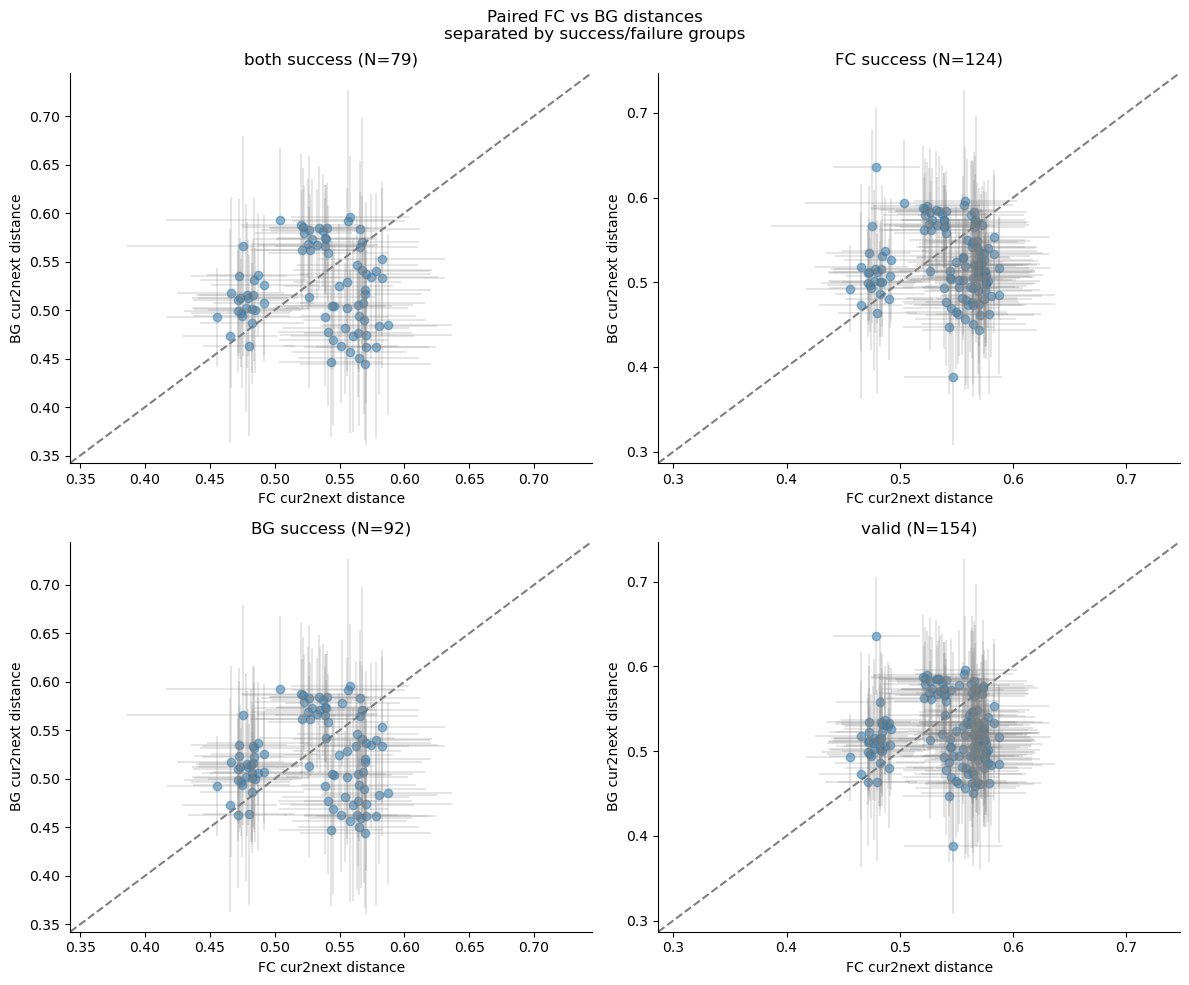

In [44]:
figh, axs = plt.subplots(2, 2, figsize=[12, 10])
for ax, mask, mask_name in zip(axs.flatten(), [bothsucmsk, FCsucsmsk, BGsucsmsk, validmsk], ["both success", "FC success", "BG success", "valid"]):   
    Exp_lists = mask[mask].index
    # Get FC and BG cur2next distances for each experiment
    fc_dist = dist_stats_syn_df.query("block == 1 and Expi in @Exp_lists and distmat_type=='FC_cur2next'")['mean']
    fc_dist_std = dist_stats_syn_df.query("block == 1 and Expi in @Exp_lists and distmat_type=='FC_cur2next'")['std']
    bg_dist = dist_stats_syn_df.query("block == 1 and Expi in @Exp_lists and distmat_type=='BG_cur2next'")['mean']
    bg_dist_std = dist_stats_syn_df.query("block == 1 and Expi in @Exp_lists and distmat_type=='BG_cur2next'")['std']
    
    # Create scatter plot
    ax.scatter(fc_dist, bg_dist, alpha=0.5)
    ax.errorbar(fc_dist, bg_dist, xerr=fc_dist_std, yerr=bg_dist_std, fmt='none', ecolor='gray', alpha=0.2)
    
    # Add connecting lines between paired points
    for fc, bg in zip(fc_dist, bg_dist):
        ax.plot([fc, fc], [bg, bg], 'gray', alpha=0.2)
        
    ax.set_xlabel("FC cur2next distance")
    ax.set_ylabel("BG cur2next distance") 
    ax.set_title(f"{mask_name} (N={len(Exp_lists)})")
    
    # Add diagonal line
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()]),
    ]
    ax.plot(lims, lims, 'k--', alpha=0.5, zorder=0)
    ax.set_xlim(lims)
    ax.set_ylim(lims)

plt.suptitle("Paired FC vs BG distances\nseparated by success/failure groups")
plt.tight_layout()
plt.show()

In [59]:
from scipy.stats import ttest_rel, ttest_ind, pearsonr


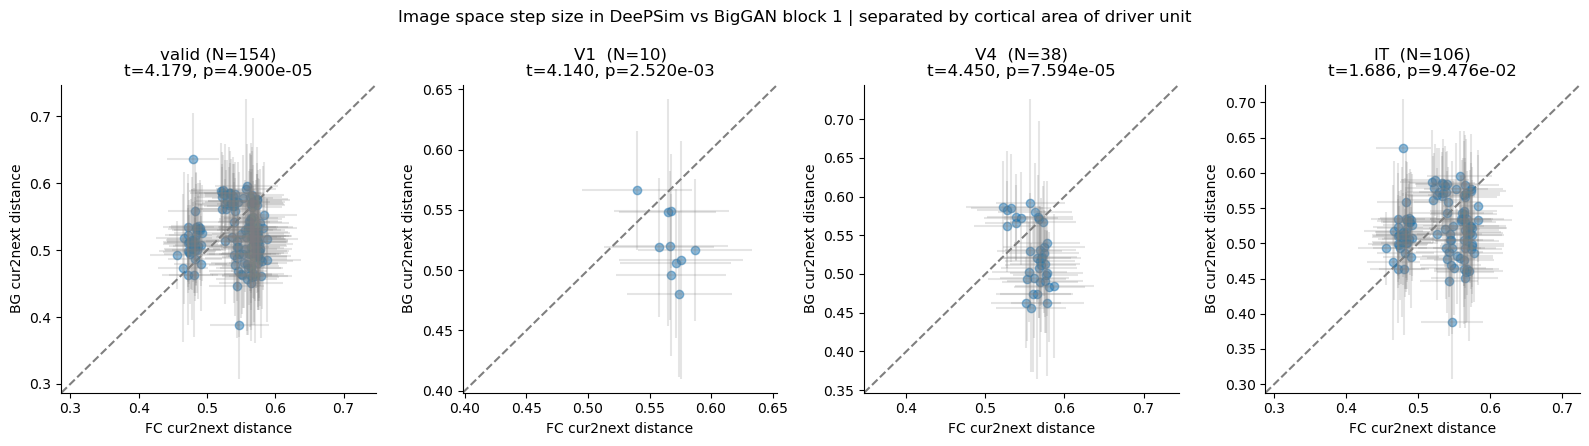

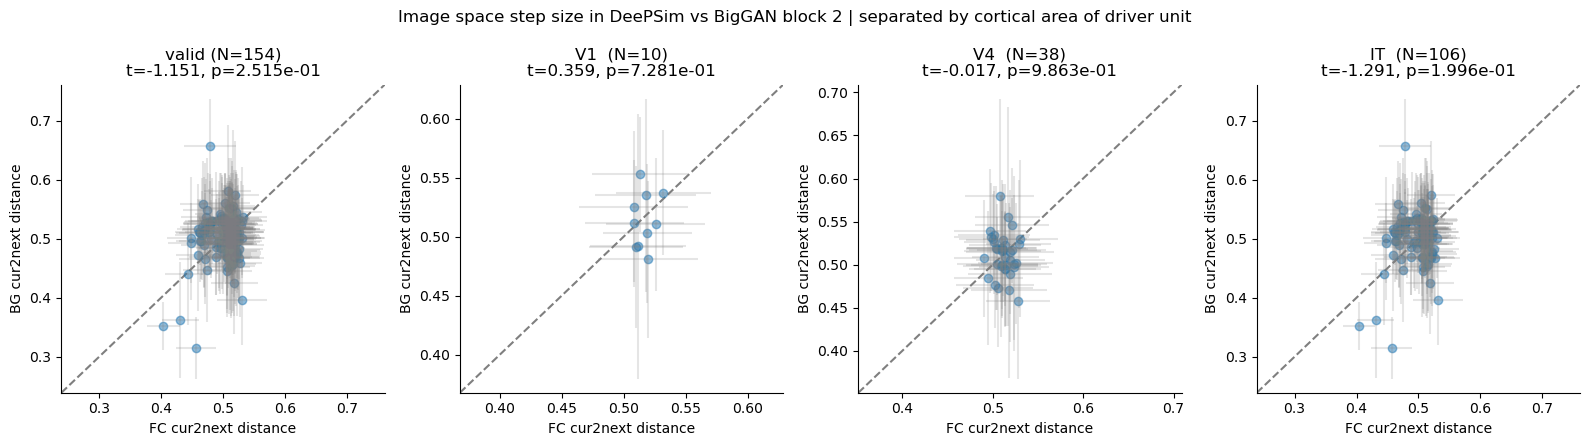

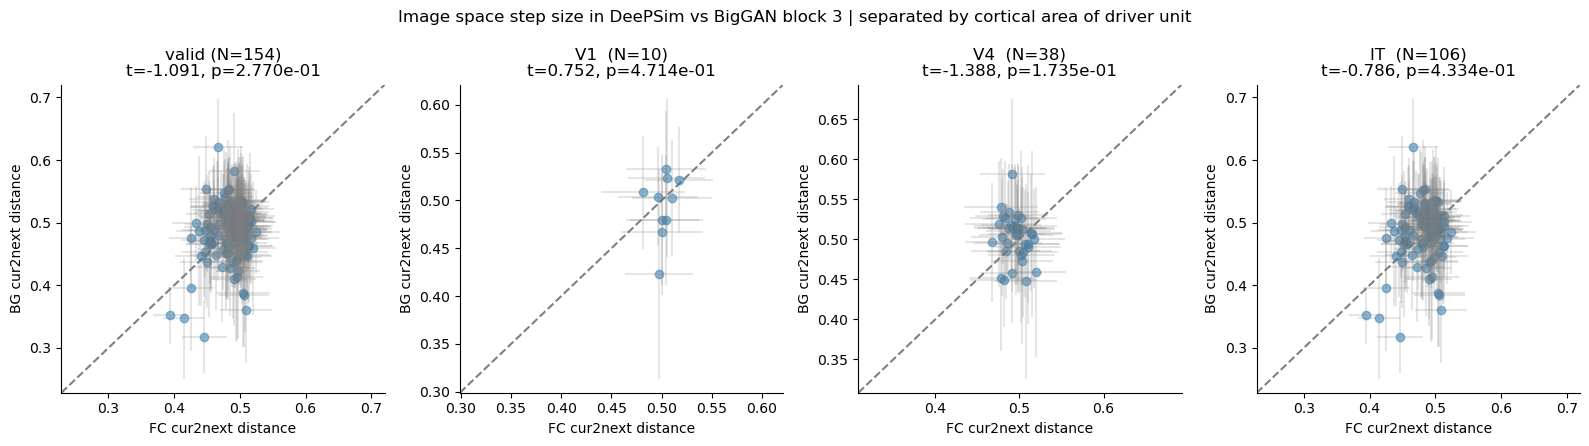

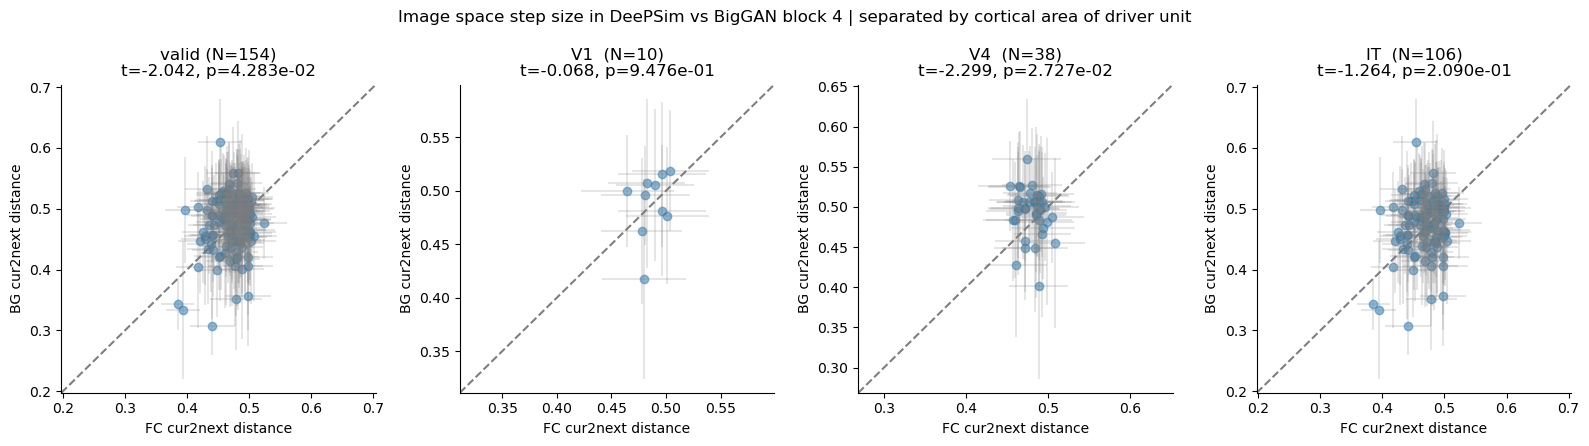

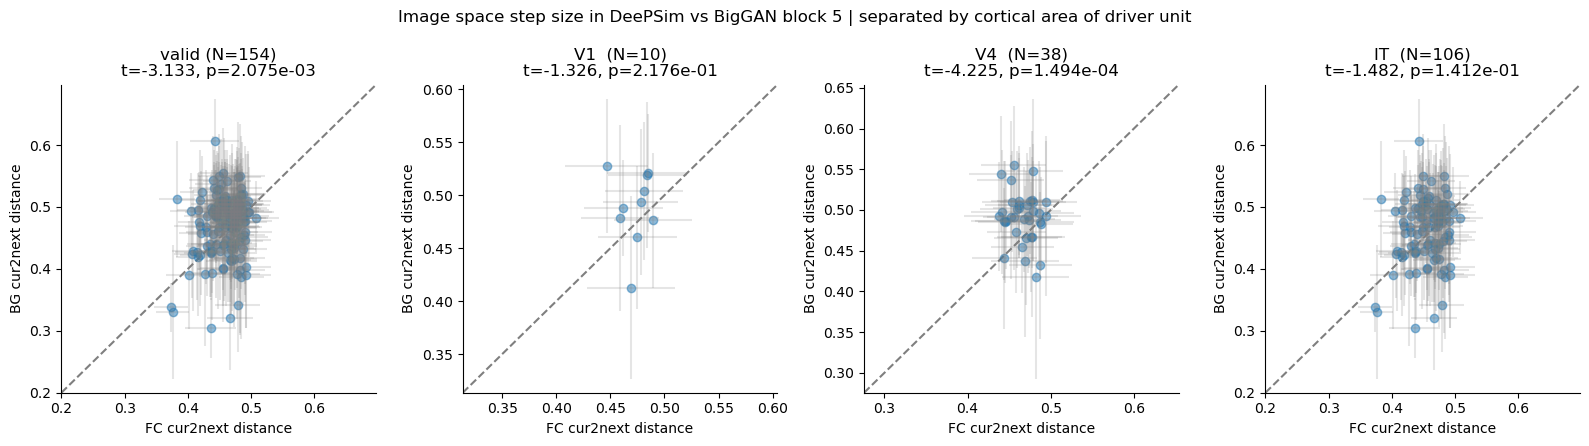

In [62]:
block_i = 2
for block_i in range(1, 6):
    figh, axs = plt.subplots(1, 4, figsize=[16, 4.5])
    for ax, mask, mask_name in zip(axs.flatten(), [validmsk, V1msk & validmsk, V4msk & validmsk, ITmsk & validmsk], ["valid", "V1 ", "V4 ", "IT "]):   
        Exp_lists = mask[mask].index
        # Get FC and BG cur2next distances for each experiment
        fc_dist = dist_stats_syn_df.query(f"block == {block_i} and Expi in @Exp_lists and distmat_type=='FC_cur2next'")['mean']
        fc_dist_std = dist_stats_syn_df.query(f"block == {block_i} and Expi in @Exp_lists and distmat_type=='FC_cur2next'")['std']
        bg_dist = dist_stats_syn_df.query(f"block == {block_i} and Expi in @Exp_lists and distmat_type=='BG_cur2next'")['mean']
        bg_dist_std = dist_stats_syn_df.query(f"block == {block_i} and Expi in @Exp_lists and distmat_type=='BG_cur2next'")['std']
        # Create scatter plot
        ax.scatter(fc_dist, bg_dist, alpha=0.5)
        ax.errorbar(fc_dist, bg_dist, xerr=fc_dist_std, yerr=bg_dist_std, fmt='none', ecolor='gray', alpha=0.2)
        
        # Perform paired t-test
        tval, pval = ttest_rel(fc_dist, bg_dist)
        
        ax.set_xlabel("FC cur2next distance")
        ax.set_ylabel("BG cur2next distance") 
        ax.set_title(f"{mask_name} (N={len(Exp_lists)})\nt={tval:.3f}, p={pval:.3e}")
        
        # Add diagonal line
        lims = [
            np.min([ax.get_xlim(), ax.get_ylim()]),
            np.max([ax.get_xlim(), ax.get_ylim()]),
        ]
        ax.plot(lims, lims, 'k--', alpha=0.5, zorder=0)
        ax.set_xlim(lims)
        ax.set_ylim(lims)

    plt.suptitle(f"Image space step size in DeePSim vs BigGAN block {block_i} | separated by cortical area of driver unit")
    plt.tight_layout()
    saveallforms(str(syndir), f"FC_BG_dist_cur2next_paired_plot_valid_V1_V4_IT_sep_block_{block_i}")
    plt.show()

In [48]:
max_blocks = dist_stats_syn_df.groupby('Expi')['block'].max()

In [50]:
# Get max block for each Expi
max_blocks = dist_stats_syn_df.groupby('Expi')['block'].max()
# Add max_block column
dist_stats_syn_df['max_block'] = dist_stats_syn_df['Expi'].map(max_blocks)
dist_stats_syn_df


,block,distmat_type,mean,std,Expi,max_block
0,1,FC_cur2next,0.471905,0.041659,3,47
1,1,BG_cur2next,0.499144,0.063215,3,47
2,1,FCBG,0.662014,0.044968,3,47
3,1,FC_curwithin,0.469829,0.095685,3,47
4,1,BG_curwithin,0.484103,0.115462,3,47
...,...,...,...,...,...,...
85,18,FC_cur2next,0.356895,0.031642,190,18
86,18,BG_cur2next,0.454526,0.068090,190,18
87,18,FCBG,0.710815,0.031008,190,18
88,18,FC_curwithin,0.349587,0.064267,190,18


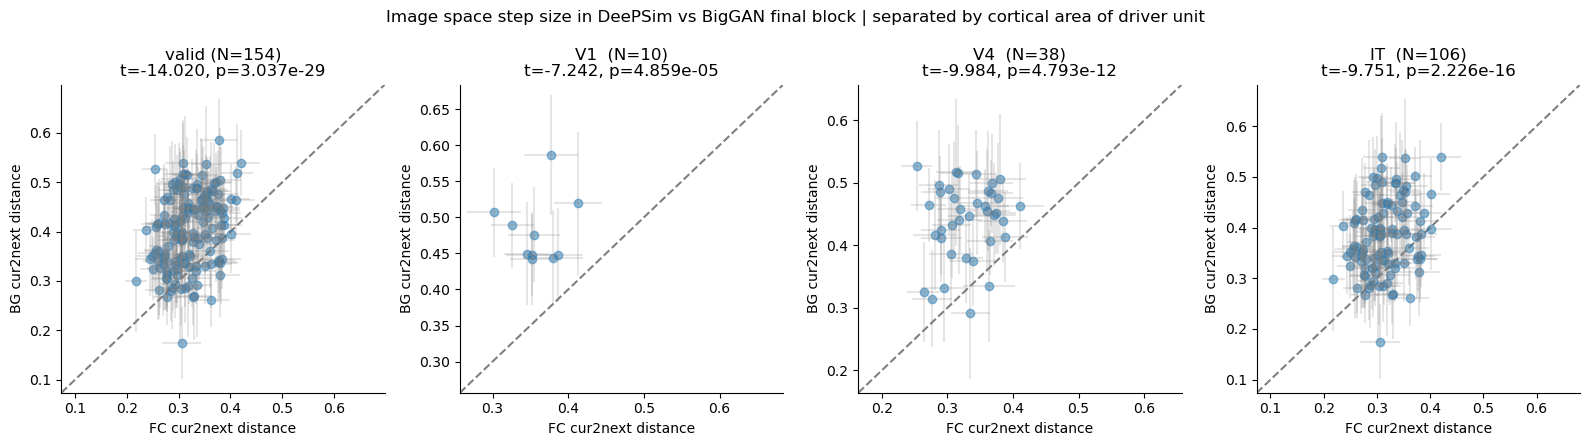

In [61]:
shift_block = 1
for shift_block in range(0, 5):
    figh, axs = plt.subplots(1, 4, figsize=[16, 4.5])
    for ax, mask, mask_name in zip(axs.flatten(), [validmsk, V1msk & validmsk, V4msk & validmsk, ITmsk & validmsk], ["valid", "V1 ", "V4 ", "IT "]):   
        Exp_lists = mask[mask].index
        # Get FC and BG cur2next distances for each experiment
        fc_dist = dist_stats_syn_df.query(f"block == max_block - {shift_block} and Expi in @Exp_lists and distmat_type=='FC_cur2next'")['mean']
        fc_dist_std = dist_stats_syn_df.query(f"block == max_block - {shift_block} and Expi in @Exp_lists and distmat_type=='FC_cur2next'")['std']
        bg_dist = dist_stats_syn_df.query(f"block == max_block - {shift_block} and Expi in @Exp_lists and distmat_type=='BG_cur2next'")['mean']
        bg_dist_std = dist_stats_syn_df.query(f"block == max_block - {shift_block} and Expi in @Exp_lists and distmat_type=='BG_cur2next'")['std']
        
        # Create scatter plot
        ax.scatter(fc_dist, bg_dist, alpha=0.5)
        ax.errorbar(fc_dist, bg_dist, xerr=fc_dist_std, yerr=bg_dist_std, fmt='none', ecolor='gray', alpha=0.2)
        
        # Perform paired t-test
        tval, pval = ttest_rel(fc_dist, bg_dist)
        
        ax.set_xlabel("FC cur2next distance")
        ax.set_ylabel("BG cur2next distance") 
        ax.set_title(f"{mask_name} (N={len(Exp_lists)})\nt={tval:.3f}, p={pval:.3e}")
        
        # Add diagonal line
        lims = [
            np.min([ax.get_xlim(), ax.get_ylim()]),
            np.max([ax.get_xlim(), ax.get_ylim()]),
        ]
        ax.plot(lims, lims, 'k--', alpha=0.5, zorder=0)
        ax.set_xlim(lims)
        ax.set_ylim(lims)
        plt.suptitle(f"Image space step size in DeePSim vs BigGAN final block | separated by cortical area of driver unit")
        plt.tight_layout()
        saveallforms(str(syndir), f"FC_BG_dist_cur2next_paired_plot_valid_V1_V4_IT_sep_block_{shift_block}to_final")
        plt.show()
